Andy Nguyen, Michael Wolfe, Spencer Fogelman, & Joseph Caguioa

DS 7331.407

Thursday 6:30pm - 8:00pm

# Visualization and Preprocessing of AirBnB Data

In [5]:
# Set-Up
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import datetime

ModuleNotFoundError: No module named 'plotly'

In [6]:
# Load Data from CSV file as pandas dataframe
df = pd.read_csv('data/airbnb_train.csv')

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

## Business Understanding

This dataset is provided by Kaggle and aims to predict the price of AirBnb listings in major cities in the United States. Each record is one AirBnB listing from 2018 with 29 attributes that describe the listing and what it offers to guests. A linear regression model would be a strong choice for predicting the continuous value of the listing price. This model could be extremely beneficial for new AirBnb hosts to guide them in setting an initial price for their listings based on location, amenities, and other features that they offered with their listing. Furthermore, the price perdiction model could help ensure that AirBnb guests are not overcharged for their stay and that hosts are adequately compensated for their hospitality. The performance of this model would be measured by the root mean square error (RMSE) to determine how far predictions deviate from actual values. Using the RMSE metric is most appropriate within this context because it heavily penalizes large errors and we want to avoid significant prediction errors in listing prices.  


In addition, the rating score from the listing reviews is a potential variable of interest that can predict if a certain listing provided guests with a positive experience during their stay. AirBnB currently employs a "Superhost" program that rewards the hosts with the most experience and highest-rated reviews.A model aimed at classifying review rating scores could provide valuable insight into how AirBnB hosts could improve their hospitality standards and provide a better experience for their guests. It would could also help new hosts better market their listings and attain superhost status. We would use misclassification rate as our performance evaluation metric with the goal of maximizing the classficiation accuracy for this type of model. A minimal misclassifcation error rate would adequately captures the attributes influencing highly-rated reviews and be useful to further our understanding of what consumers look for when searching for an AirBnb listing to book.

* **Recall vs. Precision?** I think we should prioritize recall for the context of this classification model.

In [7]:
# Quick snapshot of Data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


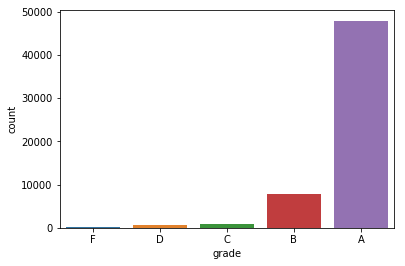

In [8]:
#Creating a categorical variable to predict based on the rating percentage
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])
df[['grade', 'review_scores_rating']].head()

#Visuals
sns.countplot(df.grade)

In [ ]:
df.groupby('grade').count()

The data shows that the majority of these listings have been reviewed with a rating score of at least 80 on a scale of 100. Following the typical rating system employed by AirBnb, 75% of these listings were rated at least 4 out of 5 stars.
* 64.6% rated at least 90 out of 100
* 10.5% rated between 80-89 out of 100
* 1.2% rated between 70-79 out of 100
* 0.8% rated between 60-69 out of 100
* 0.3% rated between 0-59 out of 100

**Note: Not all listings in this dataset were given a rating score from reviews. This issue of missing data should be resolved before building a classification model for recommended listings.**

In [9]:
df['price'] = np.exp(df['log_price'])

The objective of the original Kaggle competition was to predict the target variable log(price). We have back-transformed this target variable to the original scale in terms of U.S. dollars ($) for easier interpretation of listing prices.

## Data Meaning Type

In [ ]:
# Description of Dataset Variables (74111x29)
df.info()

This dataset originally contains 74,111 records and 29 columns. The addition of the 'grade' and 'price' variable brings the total number of columns to 31 variable.

In [ ]:
# Summary Table describing each variable with its measurement scale, data type, brief interpretation of the attribute,
# and the percentage of missing data records

fig = go.Figure(data=[go.Table(
                    header = dict(values = ["Attribute","Measurement Scale",
                                            "Data Type","Description","%datamissing"],
                                  fill_color = 'paleturquoise',
                                  align = 'left'),
                    cells = dict(values = [df.columns, # Attributes
                        # Measurement Scale  
                        ["Nominal","Interval","Nominal","Nominal","Nominal","Interval","Interval",
                        "Nominal","Ordinal","Nominal","Nominal","Nominal","Ordinal","Nominal",
                        "Nominal","Ratio","Ordinal","Nominal","Ordinal","Interval","Interval",
                        "Nominal","Nominal","Interval","Ratio","Nominal","Nominal","Interval",
                        "Interval","Ordinal","Ratio"],
                        # Data Type                    
                        ["int64","float64","object","object","object","int64","float64","object","object",
                        "bool","object","object","datetime","bool","bool","float64","datetime","bool",
                        "datetime","float64","float64","object","object","int64","float64","object",
                        "object","int64","int64","category","float64"],
                        # Description
                        ["Unique Identifier for listing","natural logarithm of the listing price",
                        "The listing's property type (i.e. House, Apartment, Condominium, etc.)",
                        "The type of room provided by the listing (i.e. Private Room, Entire home/apt, etc.)",
                        "Amenities the listing provides (i.e. TV, WIFI, A/C, Parking, Kitchen, etc.)",
                        "Number of guests the listing can accomodate",
                        "Number of bathrooms the listing provides", 
                        "The type of beds the listing provides (i.e. Real Bed, Air Mattress, Futon, etc.)",
                        "Level of cancellation policy regarding refunds for reservations at the listing (i.e. flexible, moderate, strict)",
                        "Does the listing charge a cleaning fee? (i.e. True or False)",
                        "The United States city where the listing is located",
                        "A description of the listing provided by the host",
                        "The date of the listing's first review (e.g. 2017-01-01)",
                        "Does the listing's host provide a profile picture? (i.e. True or False)",
                        "Has the listing's host verified their identification with AirBnb? (i.e. True or False)",
                        "Host's response rate to all guest inquiries (i.e. 0-100%)",
                        "Date when host first listed their property with Airbnb (e.g. 2017-01-01)",
                        "Can the listing be instantly booked (i.e. True or False)",
                        "Date of the listing's last review from an AirBnb guest",
                        "Latitude Coordinates of the listing",
                        "Longitude Coordinates of the listing",
                        "The name identifying the listing in AirBnb property searches",
                        "The neighborhood in the United States where the listing is located",
                        "The number of reviews the listing has received from previous guests",
                        "The AirBnB rating score compiled from all the listing's reviews",
                        "The thumbnail url associated with the listing",
                        "The United States zipcode where the listing is located in",
                        "The number of bedrooms the listing provides",
                        "The number of beds the listing provides",
                        "The grade assigned to the listing based on its reviews rating score",
                        "The listing's price in U.S. dollars ($)"],
                        # %datamissing
                        ["0%","0%","0%","0%","0%","0%","0.3%","0%","0%","0%","0%","0%","21%",
                        "0.3%","0.3%","25%","0.3%","0%","21%","0%","0%","0%","9%","0%","23%",
                        "11%","1.3%","0.1%","0.2%","23%","0%"]],
                                 fill_color = 'lavender',
                                 align = 'left')
)])
fig.show()

AirBnb defines their Superhost program as system that rewards Airbnb hosts with the highest-rated reviews and most experience. It offers Superhosts enchanced opportunities to earn extra money, attract more guests, and access to exclusive rewards as incentive to continue providing exceptional hospitality to guests.

The requirements for Superhost eligibility are: a **4.8+ overall rating, 10+ stays, <1% cancellation rate, and 90% response rate**. This criteria establishes our baseline understanding for how these listings and hosts should be recommended to future AirBnb guests.

Given the unbalanced levels of the review rating scores as seen in the grade variable visualization, we will consider extracting a new binary response variable from the data with 96/100 as a potential cutoff threshold (4.8/5 overall stars). This value may be changed to optimize the classification model once we actually begin the training steps.

## Data Quality

We have decided to remove all instances with missing values for review_scores_rating (the variable we will be deriving our categorial response variable from) to avoid any complications introducted into a classification model by imputing values into the target response variable. This results in 57,389 listings remaining, and we believe a dataset of this size provides sufficient information to train a high-performing model.

In [10]:
df_ratings = df.dropna(subset=['review_scores_rating'])

**Variables with Float Data Types**
* log_price, latitude, longitude, review_scores_rating, price

**Variables with Integer Data Types**
* id, accomodates, bathrooms, number_of_reviews, bedrooms, beds

**Categortical Variables (Multiple levels/factors)**
* property_type, room_type, bed_type, cancellation_policy, city, neighbourhood, zipcode, grade

**Variables with Boolean Data Types**
* cleaning_fee, host_has_profile_pic, host_identity_verified

**Variables with Date-Time Data Types**
* first_review, host_since, last_review

**Variables with String Data Types**
* amenities (list of strings), description, name, thumbnail_url


In [11]:
# Data Type Manipulation
# Float Data Types
## Bathrooms is Interval Measurement Scale but Float Data Type to account for 1/2 bathrooms
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
# Drop % in host_response_rate values and transform to float value (100% = 1.0)
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100

# Int Data Types
## We are unable to transform the bedrooms and beds variables to an integer data type due to missing values
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
# df_ratings[ints][df_ratings[ints].notna()] = df_ratings[ints][df_ratings[ints].notna()].astype(np.int64)

# Datetime Types
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)

# Bool Types
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)

# Categorical Features
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [29]:
df_ratings.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57389 entries, 0 to 74110
Data columns (total 31 columns):
id                        57389 non-null int64
log_price                 57389 non-null float64
property_type             57389 non-null category
room_type                 57389 non-null category
amenities                 57389 non-null object
accommodates              57389 non-null int64
bathrooms                 57230 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
description               57389 non-null object
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        48003 non-null float64
host_since                57248 non-null datetime64[ns]
instant_bookable          57389 non-null bool
last_rev

There were no duplicate records found after dropping all records with missing values for review_scores_rating.

Missing values for the neighbourhood, zipcode, and thumbnail_url attributes may have been the result of data scraping or collection errors. Since the city, latitude, and longitude variables do not contain missing values, we decided against imputing values for the neighbourhood and zipcode attributes to avoid introducing unnecessary complications into our model. We believe that the city, latitude, and longitude variables provide sufficient information pertaining to the location of the listing. As a result, we will potentially exclude the the neighbourhood and zipcode attributes when training our model. Furthemore, the thumbnail_url attribute does not provide much value in predicting either of our potential target response variables. We will not impute values for the missing data and will also exclude this attribute when training our model.

In [12]:
# Record with missing value for first_review and last_review
df_ratings[df_ratings.first_review.isna()]

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,grade,price
33984,7765579,4.59512,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2,1.0,Real Bed,strict,True,NYC,"Our super comfortable, clean and cool room, wi...",NaT,True,True,1.0,2013-09-29,False,NaT,40.663137,-73.932994,The Heights Rentals III,East Flatbush,1,20.0,https://a0.muscache.com/im/pictures/632b80ab-d...,11203.0,1.0,1.0,F,99.0


The record with the missing value for first_review and last_review is the same (id#33984 - Name: "The Heights Rentals III"). A closer look at this data record shows that it only has one review with a review_scores_rating of 20. Given that this dataset has been most recently updated in 2018 and the host originally listed the property on 2013-09-29, we have reason to believe that this AirBnb listing is no longer active and that those data values were inaccesible. We will consider dropping this record from the dataset when training our models.

In [113]:
# Impute Missing Values of host_since variable with first_review data value from same record
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We believe that the listings with missing values for the host_since variable may be the result of a host that has multiple AirBnB listings where the data value for this particular attribute is only associated with the first listing they originally began hosting through AirBnb. We found that a suitable strategy to address these missing values would be to impute them with the value from the first_review variable for that corresponding listing. The best estimate to minimize the loss of information from missing values of the host_since variable would be the date of the first review because these two attributes should be intuitively close in time. An imputation based on statistical averages such as mean, median, or mode would be arbitrary and may even conflict with the information provided from the first_review data value. For example, it would not make sense to impute a date for the host_since variable for a certain listing that is more recent in time than its first_review date value.

The missing values for the bathrooms, bedrooms, and beds attributes may have been a result of host input error. We believe that the hosts for these respective listings forgot to include this data when posting their property as an AirBnb listing. Thus, resulting in the omission of this information in the dataset for these certain listings. Based on our reasoning, we believed that the best imputation method for these missing values should be based on the property type and the number of guests the listing can accomodate. These variables generally provide a great determination of how many bathrooms, bedrooms, and beds are avaiable with the AirBnb listing. We decided to impute these missing values with the median because the mean value would not be a whole number and would thus not make sense in the context of bedrooms or beds.

In [11]:
# Code to determine missing values and imputation value for bathrooms by property type and accommodation number
## df_ratings[df_ratings.bathrooms.isna()].groupby(["property_type","accommodates"])["property_type"].count()
## df_ratings.groupby(["property_type","accommodates"])['bathrooms'].describe()

# Code to determine missing values and imputation value for bedrooms by property type and accommodation number
## df_ratings[df_ratings.bedrooms.isna()].groupby(["property_type","accommodates"])["property_type"].count()
## df_ratings.groupby(["property_type","accommodates"])['bedrooms'].median()

# Code to determine missing values and imputation value for beds by property type and accommodation number
## df_ratings[df_ratings.beds.isna()].groupby(["property_type","accommodates"])["property_type"].count()
## df_ratings.groupby(["property_type","accommodates"])['beds'].median()

In [14]:
# Impute Missing Values of Bathroom Variable
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Impute Missing Values for Bathrooms with median values based on Property Type & Accomodates**
* 159 missing values for bathrooms
    * Impute Apartments accommodating (1-5) w/ 1 bathroom (100 values)
    * Impute Bed & Breakfast accommodating (1-2) w/ 1 bathroom (3 values)
    * Impute Camper/RV accomodating 2 w/ 1 bathroom (1 value)
    * Impute Dorm accomodating (1-2) w/ 1 bathroom (8 values)
    * Impute House accomodating (1-4) w/ 1 bathroom (39 values)
    * Impute House accomodating 6 w/ 2 bathrooms (1 value)
    * Impute House accomodating 8 w/ 2.5 bathrooms (1 value)
    * Impute House accomodating 16 w/ 3 bathrooms (1 value)
    * Impute Loft accomodating 2 w/ 1 bathroom (1 value)
    * Impute Other accomodating (2-4) w/ 1 bathroom (4 values) 

In [16]:
# Impute Missing Values of Bedrooms Variable
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Impute Missing Values for Bedrooms with median values based on Property Type & Accomodates**
* 70 missing values for bedrooms
    * Impute Apartments accomodating (1-4) w/ 1 bedroom (57 values)
    * Impute Bungalow accomodating 3 w/ 1 bedroom (1 value)
    * Impute House accomodating 2 w/ 1 bedroom (7 values)
    * Impute House accomodating 6 w/ 3 bedroom (1 value)
    * Impute Loft accomodating 4 w/ 1 bedroom (3 values)
    * Impute Other accomodating 1 w/ 1 bedroom (1 value)

In [17]:
# Impute Missing Values of Beds Variable
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Impute Missing Values for Beds with median values based on Property Type & Accomodates**
* 62 missing values for beds
    * Impute Apartments accomodating (1-3) w/ 1 bed (38 values)
    * Impute Apartments accomoodating 4 w/ 2 beds (1 value)
    * Impute Condominium accomodating 2 w/ 1 bed (1 value)
    * Impute Dorm accomodating 1 w/ 1 bed (1 value)
    * Impute Guesthouse accomodating 1 w/ 1 bed (1 value)
    * Impute House accomodating (1-2) w/ 1 bed (14 values)
    * Impute House accomodating 3 w/ 2 beds (1 values)
    * Impute House accomodating 5 w/ 3 beds (1 value)
    * Impute House accomodating 16 w/ 8 beds (1 value)
    * Impute Other accomodating (1-2) w/ 1 bed (2 values)
    * Impute Townhouse accomodating 2 w/ 1 bed (1 value)

In [18]:
# Impute Missing Values of host_response_rate Variable
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We found that most of the missing values for the host_response_rate variable came from listings that only had a few reviews. This suggests that these first few guests may have not interacted with the host much so there is not enough information to provide data regarding the host_response_rate for these listings. We decided to impute these missing values with the mean based on the number of reviews and avoid using the review_rating_score data since it is a potential target variable we could predict.

In [19]:
# We can now change bedrooms and beds data type to integers now that we have addressed the missing values
df_imputed[ints] = df_imputed[ints].astype(np.int64)
df_imputed.info()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 57389 entries, 0 to 74110
Data columns (total 31 columns):
id                        57389 non-null int64
log_price                 57389 non-null float64
property_type             57389 non-null category
room_type                 57389 non-null category
amenities                 57389 non-null object
accommodates              57389 non-null int64
bathrooms                 57389 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
description               57389 non-null object
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        57388 non-null float64
host_since                57248 non-null datetime64[ns]
instant_bookable          57389 non-null bool
last_rev

In [20]:
# Records with missing value for host_response_rate
df_ratings[df_ratings.host_response_rate.isna()]

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,grade,price
48194,19947126,4.094345,Apartment,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,flexible,False,Boston,"Comfy queen-size bed, free breakfast, clean sh...",2013-06-08,True,True,NaN,2011-12-07,True,2017-06-20,42.294442,-71.119945,Boston Room/Free Transit/ By Subway,Jamaica Plain,344,96.0,https://a0.muscache.com/im/pictures/31278262/b...,02131,1,1,A,60.0


## Simple Statistics

In [118]:
df_imputed.describe()

,id,log_price,accommodates,bathrooms,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,price
count,5.738900e+04,57389.000000,57389.000000,57389.000000,57388.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000
mean,1.125208e+07,4.749232,3.218247,1.225967,0.952632,38.485767,-92.352714,26.957326,94.067365,1.260904,1.737546,147.748297
std,6.082797e+06,0.668700,2.144154,0.561473,0.122001,3.085702,21.670682,41.043449,7.836556,0.841280,1.265311,134.512852
min,3.440000e+02,0.000000,1.000000,0.000000,0.000000,33.338905,-122.511500,1.000000,20.000000,0.000000,0.000000,1.000000
25%,6.248838e+06,4.304065,2.000000,1.000000,0.940000,34.127760,-118.340924,3.000000,92.000000,1.000000,1.000000,74.000000
50%,1.222387e+07,4.700480,2.000000,1.000000,1.000000,40.668884,-76.995077,11.000000,96.000000,1.000000,1.000000,110.000000
75%,1.639709e+07,5.164786,4.000000,1.000000,1.000000,40.749182,-73.954325,33.000000,100.000000,1.000000,2.000000,175.000000
max,2.123090e+07,7.600402,16.000000,8.000000,1.000000,42.390437,-71.000261,605.000000,100.000000,10.000000,18.000000,1999.000000


The above call provides summary statistics on all integer and float variables. For ID, latitude, and longitude, these are not particularly meaningful.

As aforementioned, log(price) was not easily interpretable and the log scale obscures some interesting details more readily apparent in the derived price variable. For one, the cheapest named price is one dollar. The actual cities where these postings were taken from, discussed in a later section, are typically expensive tourist destinations. Very cheap prices are not unheard of, and while this could be a data collection error, the other columns associated with the entry seem legitimate.

In [ ]:
df_imputed.loc[df['price'] == 1]

In [ ]:
df_imputed.loc[df['price'] > 1995].head(3)

On the other end of the scale is the maximum price, at nearly two thousand dollars per night. Multiple properties aim to differentiate themselves with such a high price point, likely for a correspondingly luxurious experience. Predictably, considering that AirBnB guests generally aim to save money on accommodations, these properties are in low demand, most with no reviews at the point of collection. Overall the average per-night cost sits near \\$160 with the 75th percentile at \\$185. This hammers home how competitive pricing is, as well as where AirBnB trends on the pricing scale compared to other lodging options such as hostels and hotels.

In terms of rooms this dataset's properties provide, on average, 1-2 bedrooms with 1-2 beds and access to one bathroom. The mean value for the accommodates variable sits slightly higher at three, suggesting most provided beds are doubles. Some anomalous entries exist here as well, such as postings for entire homes with at least one bed yet bedrooms at zero, or a handful of entries describing zero real beds. These are likely errors or misunderstandings on the part of the host.

Reviews are discussed further alongside graphs to better visualize distributions related to their quantity and score, but the summary statistics alone provide some insight as well. The median number of reviews is 6, a relatively low number that could be attributable to some combination of unreviewed listings, the fact that not all guests write reviews, and the part-time side gig nature of AirBnB for some hosts. Average ratings out of 100 look overwhelmingly high, with the 25th percentile being 92.

## Visualize Attributes

In [1]:
# Import visualization packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Density')

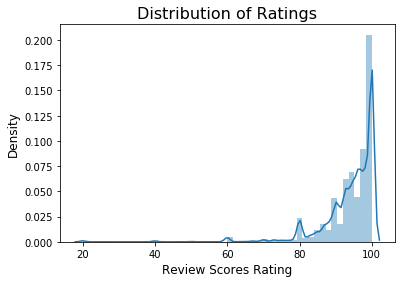

In [22]:
# Histogram for review_scores_rating, a float
sns.distplot(df_imputed['review_scores_rating'])
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Review Scores Rating', fontsize=12)
plt.ylabel('Density', fontsize=12)

Plotting the ratings reveals a long left tail, with most ratings concentrated in the 80-100 score range. This is likely due to AirBnb's rating system, where guests rate their stay on a scale of 1 to 5 stars. Furthermore, properties that fall below a certain rating average get delisted. Combined, this likely results in an artificially biased sample where consistently strong performers are overrepresented. This is explored further in a later section.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Density')

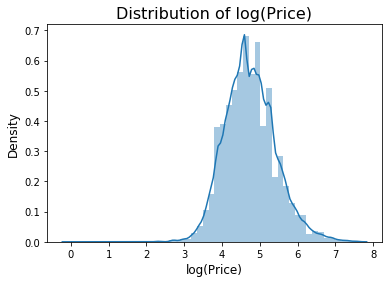

In [23]:
sns.distplot(df_imputed['log_price'])
plt.title('Distribution of log(Price)', fontsize=16)
plt.xlabel('log(Price)', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0,0.5,'Frequency')

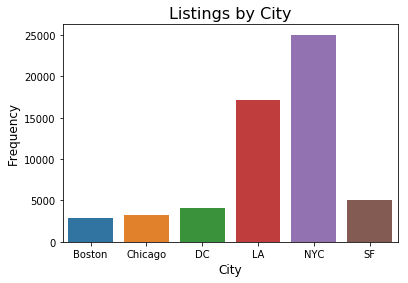

In [25]:
# Bar graph for city, a factor
sns.countplot(x="city", data=df_imputed)
plt.title('Listings by City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

Text(0.5,1,'Host Has Profile Picture')

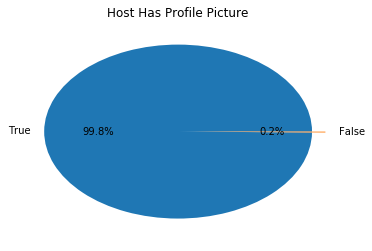

In [47]:
# Pie chart of host_has_profile_pic, a binary variable
explode_profile = (0, 0.1)
labels_profile = ("True", "False")
profile_pics = df_imputed['host_has_profile_pic'].value_counts()
plt.pie(profile_pics, explode=explode_profile, labels=labels_profile,
       autopct='%1.1f%%')
plt.title('Host Has Profile Picture')

Text(0.5,1,'Host Identity Verified')

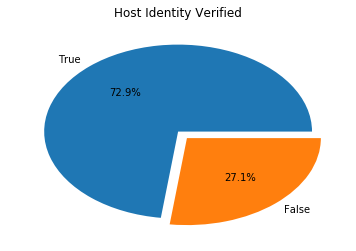

In [53]:
# Pie chart of host_identity_verified
identity_verified = df_imputed['host_identity_verified'].value_counts()
labels_verified = ("True", "False")
explode_verified = (0, 0.1)
plt.pie(identity_verified, autopct='%1.1f%%', explode=explode_verified,
       labels=labels_verified)
plt.title('Host Identity Verified')


## Explore Joint Attributes

In [ ]:
#need to resize this
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10)) 
corr = df_ratings.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True,
           ax=ax)

A heatmap of all the attributes reveals a few positive correlations between certain attributes. Log price and accomodation numbers are positively correlated according to the heatmap, with a coefficient of 0.82. This might indicate a higher price for listings that accommodate more people.

In [ ]:
sns.scatterplot('log_price', 'accommodates', data=df_ratings)

## Explore Attributes & Class

In [ ]:
# Scatterplot between rating and number of reviews
sns.regplot(x='review_scores_rating', 
            y='number_of_reviews',
            data=df_ratings,
            scatter_kws={'alpha':0.1})
plt.title('Reviews: Quantity and Average', fontsize=16)
plt.xlabel('Review Scores Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

Due to the sheer amount of data, introducing transparency to individual points in the scatterplot helps show some nuance about the distribution. While the concentration of scores in the 70-100 score range is high, there are also darkened overlapping concentrations on the lower end. This is likely an artifact of the 5-star scoring system, which suggests a decent number of properties had an average of 1, 2, 2.5, or 3 stars.

As suggested earlier, properties that maintain high-quality as judged by guests are permitted to remain listed on AirBnB, resulting in said properties continuing to accumulate reviews. While one interpretation is that guests simply filter for highly rated properties, it is more likely that poor performers get a limited opportunity to get their act together before being dropped in order to maintain quality across the site.

In [ ]:
np.average(df_ratings['number_of_reviews'], weights=(df_ratings['review_scores_rating'] <= 60))

In [ ]:
(df_ratings['review_scores_rating'] <= 60).sum()

Some quick calculations show that listings earning 3 stars and below usually had only 1-2 reviews.

In [ ]:
# Violin plots of price by city
sns.violinplot(x="city", y="price", data=df_ratings)
plt.title('Price by City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Price, USD', fontsize=12)

Violin plots of untransformed price among the six cities in the dataset reveals long tails caused by the expensive outliers. All six cities have at least one listing going for around \\$1,500 a night. In order to better see the data, we can cut down to a value slightly above the 75th percentile at \\$185.

In [ ]:
# Violin plots of price by city, removing outliers
sns.violinplot(x="city", y="price", data=df_ratings[df_ratings.price < 300])
plt.title('Closer Look at Price by City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Price, USD (axis zoomed in)', fontsize=12)

This view enables us to see the slightly higher price distribution of San Francisco and the higher density of sub-\\$100 postings in New York City, Los Angeles, and Chicago.

In [ ]:
plt.figure(figsize = (10, 200))
sns.boxplot(x="log_price", y="neighbourhood", hue="city", data=df_ratings,
           width=0.8, fliersize=2, dodge=False)

Plotting log(price) against neighborhood names is an easier visualization to handle than using regular price. Of note, some neighborhood names have two or more box colors appear (*e.g.*, Downtown, Chinatown), which makes sense because the same neighborhood name can be shared across different cities.

## New Features

Additional potential features could be engineered from existing attributes or derived from the original AirBnB listings.

* <s>While log price is the original target variable, it would make sense to create a price variable that simply back-transforms the value into something more easily human-readable and business-relevant.</s>
* A general sense for the size of the listing could be obtained from principal component analysis on accommodates, bathrooms, bedrooms, and beds. This would also likely need to account for the property and room type factors, which mention what kind and how much of the property is available to guests.
* Clustering could be performed using some combination of latitude, longitude, city, and neighborhood to get a sense for pricing trends based on physical location.
* On a related note, hosts frequently use description and name to advertise a property's proximity to popular tourist destinations, public transportation, or restaurants and nightlife. Sentiment analysis on the significance of a property's physical location could give clues about pricing.
    * For a less subjective alternative, one could bring in the latitude-longitude coordinates of known highlights in a given city and then calculate distance from the property. This could be captured in binary variables, such as whether a property is located within 0.25 miles of a public transport stop or within a city's tourist district.
* Current variables related to reviews are about quantity, scores, or dates. Sentiment analysis could be performed on select reviews (e.g., first, most recent, highest rating, lowest rating) to gain an understanding of why certain guests submitted a given score. For example, perhaps a listing's major strength is its host, and multiple reviews mention the host's hospitality and knowledge about the area. Such details are not currently captured by host-related variables in the dataset. 
    * Review text may also support a host's claims made about proximity in the description and name.

## Exceptional Work

In [ ]:
#New attributes by exploring the attributes column
df['internet'] = df.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
print(df[['internet', 'amenities']].head())

df['TV'] = df.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
print(df[['TV', 'amenities']].head())

df['air_conditioning'] = df.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
print(df[['air_conditioning', 'amenities']].head())

df['kitchen'] = df.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
print(df[['kitchen', 'amenities']].head())

df['pool'] = df.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
print(df[['pool', 'amenities']].head())

df['parking'] = df.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)
print(df[['parking', 'amenities']].head())

#We will also make a new price variable that is not logged
df['price'] = np.exp(df['log_price'])